# Chapter 8 Tree-Based Methods

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
from IPython.display import Image
from io import StringIO
import os

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

%matplotlib inline

### Udf

In [2]:
def print_tree(estimator, features, class_names=None, filled=True):
    '''
    Creates images of tree models using pydot.
    '''
    tree = estimator
    names = features
    color = filled
    classn = class_names
    
    dot_data = StringIO()
    export_graphviz(estimator, out_file=dot_data, feature_names=features, class_names=classn, filled=filled)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    return graph

## 8.3.1 Fitting Classification Trees

**pd.factorize** - Encode the object as an enumerated type or categorical variable. This method is useful for obtaining a numeric representation of an array when all that matters is identifying distinct values. 

In [15]:
url_path = os.path.abspath('..')
carseats = pd.read_csv(url_path + '/data/Carseats.csv')
carseats['is_sales_high'] = carseats['Sales'].map(lambda x: 1 if x > 8 else 0)
carseats['ShelveLoc'] = pd.factorize(carseats['ShelveLoc'])[0]
carseats['Urban'] = carseats['Urban'].map({'No':0, 'Yes': 1})
carseats['US'] = carseats['US'].map({'No': 0, 'Yes': 1})
carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,is_sales_high
0,9.50,138,73,11,276,120,0,42,17,1,1,1
1,11.22,111,48,16,260,83,1,65,10,1,1,1
2,10.06,113,35,10,269,80,2,59,12,1,1,1
3,7.40,117,100,4,466,97,2,55,14,1,1,0
4,4.15,141,64,3,340,128,0,38,13,1,0,0


In [16]:
carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sales          400 non-null    float64
 1   CompPrice      400 non-null    int64  
 2   Income         400 non-null    int64  
 3   Advertising    400 non-null    int64  
 4   Population     400 non-null    int64  
 5   Price          400 non-null    int64  
 6   ShelveLoc      400 non-null    int64  
 7   Age            400 non-null    int64  
 8   Education      400 non-null    int64  
 9   Urban          400 non-null    int64  
 10  US             400 non-null    int64  
 11  is_sales_high  400 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 37.6 KB


In [17]:
X = carseats.drop(['Sales', 'is_sales_high'], axis=1)
y = carseats['is_sales_high']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [21]:
clf = DecisionTreeClassifier(max_depth=6)
clf.fit(X_train, y_train)
train_accuracy = clf.score(X_train, y_train)

print("Training Set Accuracy Score: {:.1%}".format(train_accuracy))

Training Set Accuracy Score: 95.5%


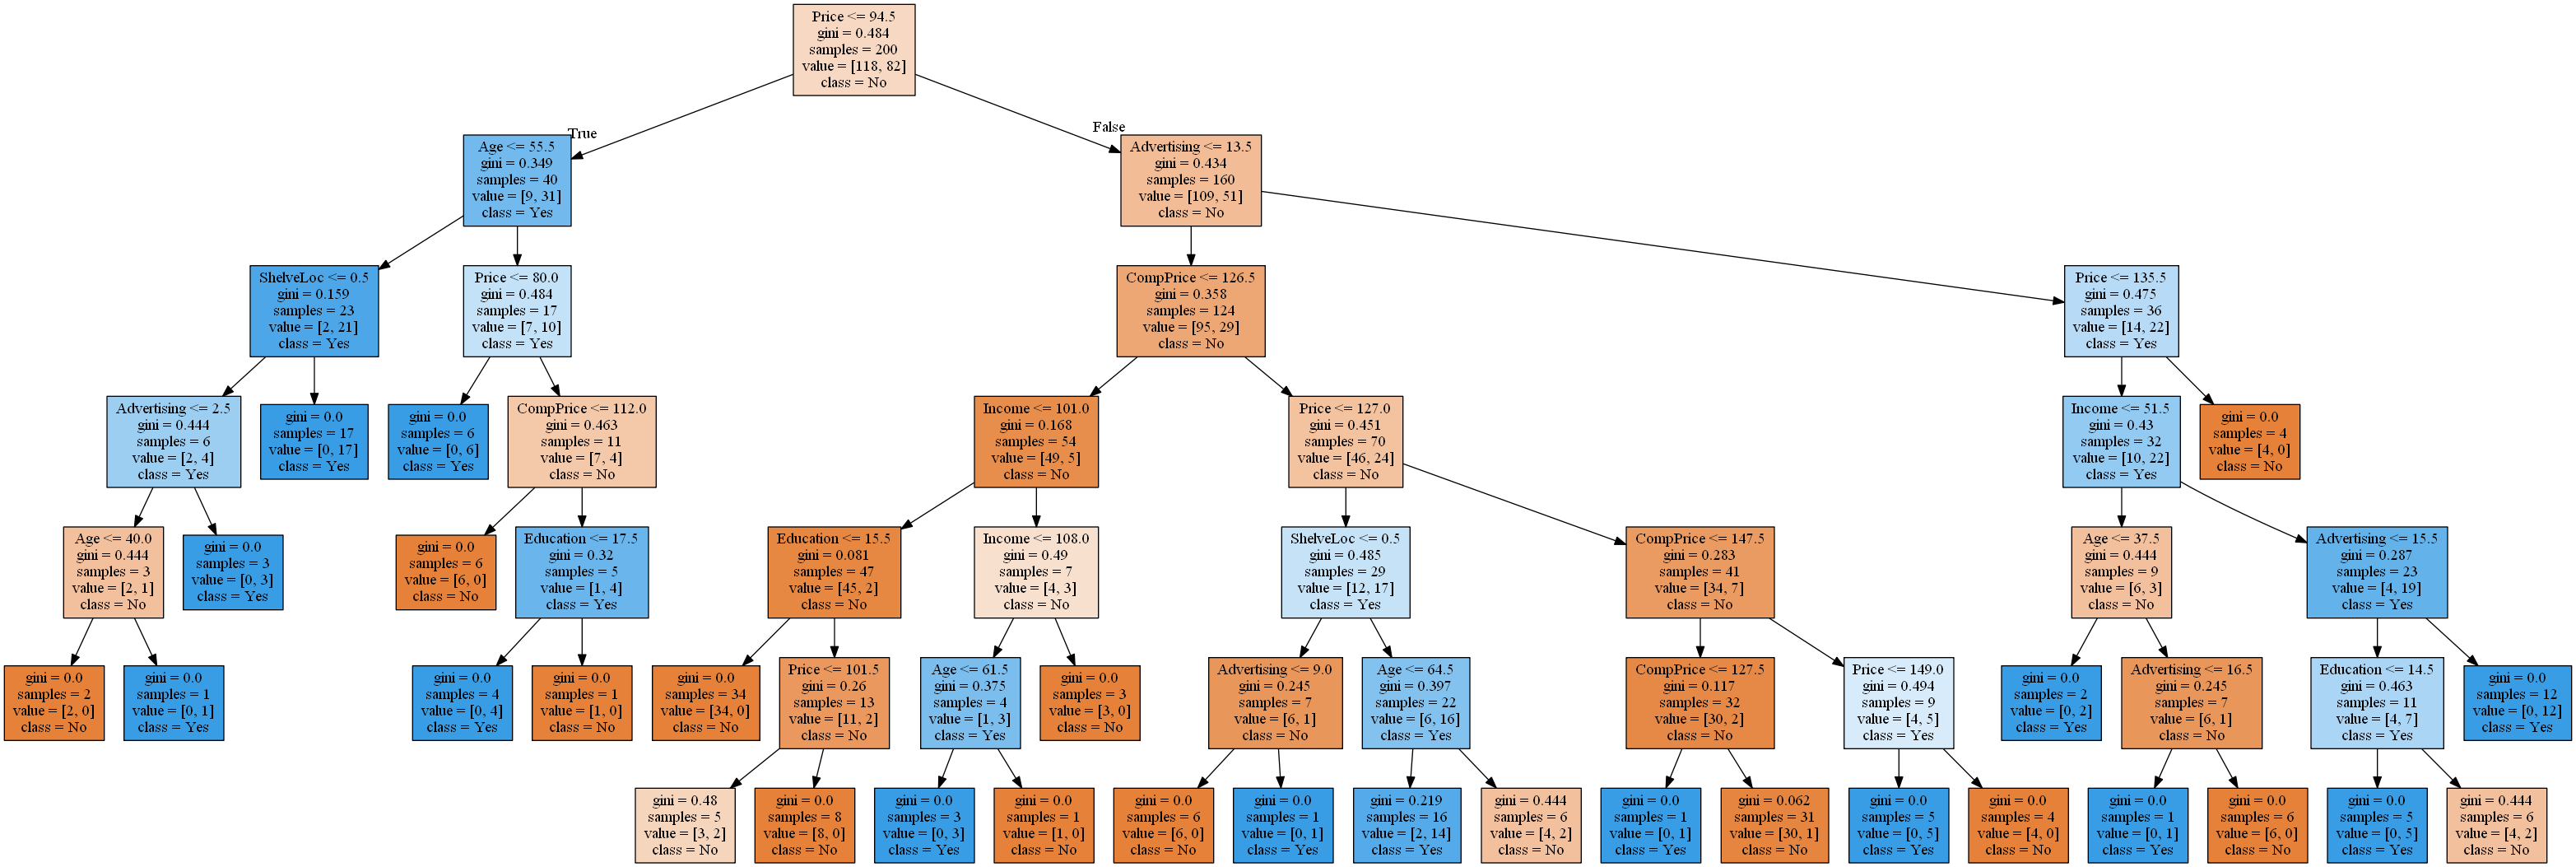

In [24]:
graph3, = print_tree(clf, features=X.columns, class_names=['No', 'Yes'])
Image(graph3.create_png())

In [25]:
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.80       118
           1       0.74      0.61      0.67        82

    accuracy                           0.75       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.75      0.75      0.75       200



In [30]:
conf_matrix = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No', 'Yes'], columns=['No', 'Yes'])
conf_matrix.index.name = 'Predicted'
conf_matrix.columns.name = 'Actual'
conf_matrix

Actual,No,Yes
Predicted,,
No,100,32
Yes,18,50


Cannot performing pruning with scikit-learn.

## 8.3.2 Fitting Regression Trees

In [12]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [13]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


#### MEDV - Median value of owner-occupied homes in $1000's

In [14]:
X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [15]:
# Pruning not supported.
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)

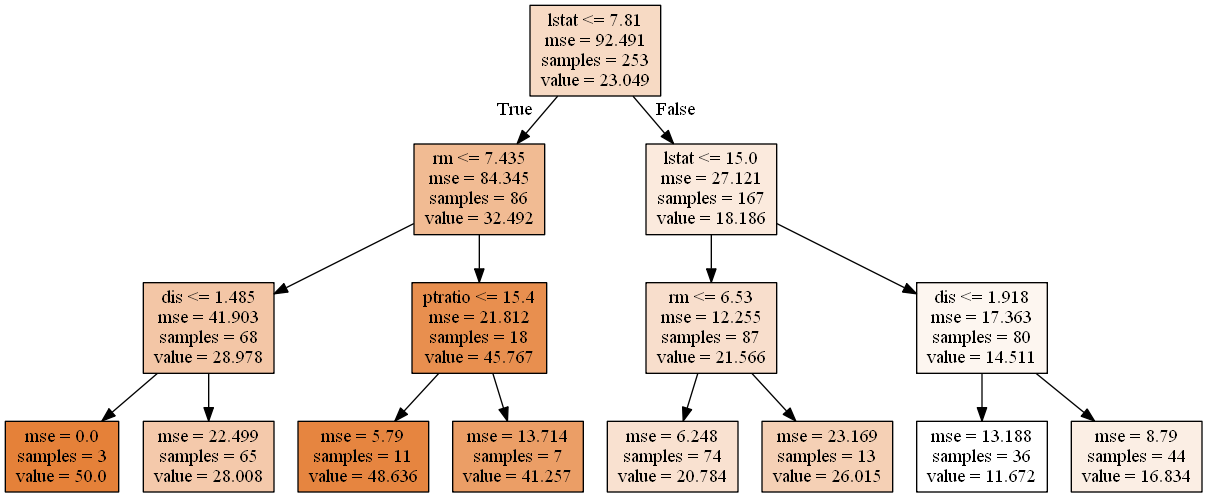

In [16]:
graph, = print_tree(regr, features=X.columns)
Image(graph.create_png())


The variable ${\tt lstat}$ measures the percentage of individuals with lower socioeconomic status. The tree indicates that lower values of ${\tt lstat}$ correspond to more expensive houses. The tree predicts a median house price of $45,766$ for larger homes (${\tt rm>=7.435}$) in suburbs in which residents have high socioeconomic status (${\tt lstat<7.81}$).

- LSTAT = % lower status of the population
- RM = average number of rooms per dwelling
- PTRATIO = pupil-teacher ratio by town
- DIS = weighted distances to five Boston employment centres

MSE:  26.02323085009744


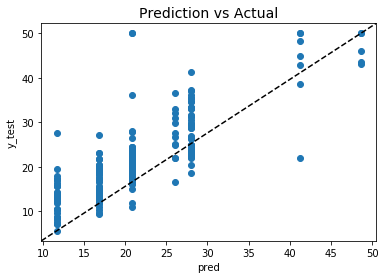

In [17]:
plt.scatter(pred, y_test, label='medv')
plt.plot([0,1], [0,1], '--k', transform=plt.gca().transAxes)
plt.title('Prediction vs Actual', fontsize=14)
plt.xlabel('pred')
plt.ylabel('y_test')

print('MSE: ', mean_squared_error(y_test, pred))


The test set MSE associated with the regression tree is **26.023**. The square root of the MSE is therefore around **5.101**, indicating that this model leads to test predictions that are within around **$5,101** of the true median home value for the suburb.

## 8.3.3. Bagging and Random Forests

The difference between bagging and random forest is that random forests decorrelate the trees. When bagging, each split considers a predictor/features from all of those available, i.e., **p** predictors. Meanwhile, a random forest selects a subset of **m** predictors/features from all those provided in the dataset.

In a random forest, a fresh set sample of **m** predictors is chosen at split candidates.

Therefore, the `RandomForestRegressor()` function can be used to perform both random forests and bagging.

In [69]:
url_path = os.path.abspath('..')
boston = pd.read_csv(url_path + '/data/Boston.csv')

X = boston.drop('medv', axis=1)
y = boston['medv']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

## Bagging

By using all available features, the `RandomForestRegressor()` can be implemented as bagging.

In [70]:
num_features = X.shape[1]
regr2 = RandomForestRegressor(max_features=num_features, random_state=1)
regr2.fit(X_train, y_train)

RandomForestRegressor(max_features=13, random_state=1)

Bagging MSE: 16.18


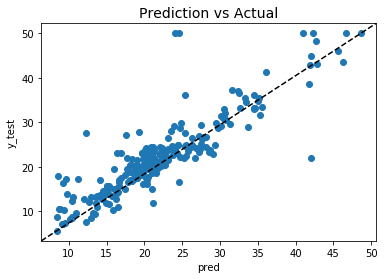

In [71]:
pred = regr2.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.title('Prediction vs Actual', fontsize=14)
plt.xlabel('pred')
plt.ylabel('y_test')
mse_regr2 = mean_squared_error(y_test, pred)
print('Bagging MSE: {:.4}'.format(mse_regr2))

## Random Forest

In [72]:
num_features = 6
regr3 = RandomForestRegressor(max_features=num_features, random_state=1)
regr3.fit(X_train, y_train)

RandomForestRegressor(max_features=6, random_state=1)

Random Forest MSE: 15.82


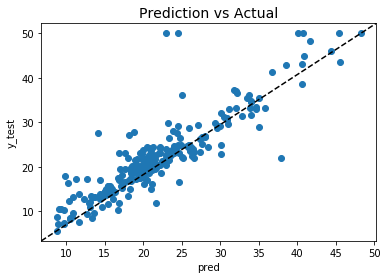

In [73]:
pred = regr3.predict(X_test)

plt.scatter(pred, y_test, label='medv')
plt.plot([0, 1], [0, 1], '--k', transform=plt.gca().transAxes)
plt.title('Prediction vs Actual', fontsize=14)
plt.xlabel('pred')
plt.ylabel('y_test')
mse_regr3 = mean_squared_error(y_test, pred)
print('Random Forest MSE: {:.4}'.format(mse_regr3))

### Feature Importance

<Figure size 504x360 with 0 Axes>

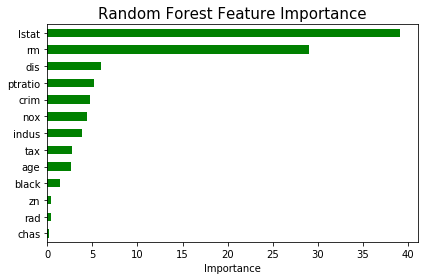

In [74]:
feature_importance = pd.DataFrame({'importance': regr3.feature_importances_*100}, index=X.columns)
feature_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

plt.figure(figsize=(7,5))
feature_importance.plot(kind='barh', color='g', legend=False)
plt.title('Random Forest Feature Importance', fontsize=15)
plt.xlabel('Importance')
plt.tight_layout();

### Permutation Importance

In [75]:
results = permutation_importance(regr3, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)
permutation_importance = pd.DataFrame({'importance': results.importances_mean*100}, index=X.columns)
permutation_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

TypeError: 'DataFrame' object is not callable

<Figure size 504x360 with 0 Axes>

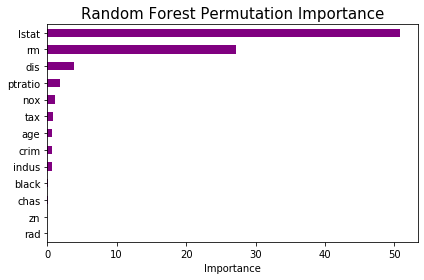

In [76]:
plt.figure(figsize=(7,5))
permutation_importance.plot(kind='barh', color='purple', legend=False)
plt.title('Random Forest Permutation Importance', fontsize=15)
plt.xlabel('Importance')
plt.tight_layout();

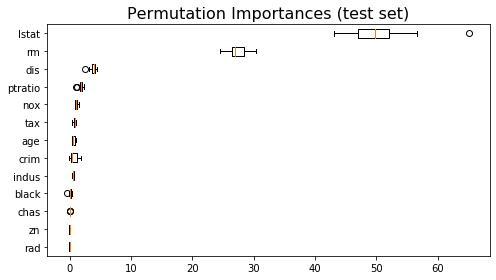

In [77]:
sorted_idx = results.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7,4))
ax.boxplot(results.importances[sorted_idx].T * 100,
          vert=False,
          labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)", fontsize=16)
fig.tight_layout();

Both permutation and feature importances concluded that the wealth level of the communit (lstat) and the house size (rm) are the most important variables.

## 8.3.4 Boosting

The argument `n_estimators=500` indicates that we want 500 trees, and the option`max_depth=4` limits the depth of each tree.

In [64]:
regr4 = GradientBoostingRegressor(n_estimators=500,
                                  learning_rate=0.01,
                                  max_depth=4,
                                  random_state=1)
regr4.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=4, n_estimators=500,
                          random_state=1)

### Feature Importance

<Figure size 504x360 with 0 Axes>

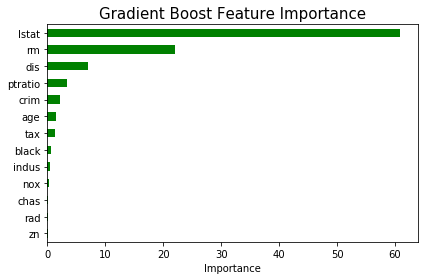

In [65]:
feature_importance = pd.DataFrame({'importance': regr4.feature_importances_*100}, index=X.columns)
feature_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

plt.figure(figsize=(7,5))
feature_importance.plot(kind='barh', color='g', legend=False)
plt.title('Gradient Boost Feature Importance', fontsize=15)
plt.xlabel('Importance')
plt.tight_layout();

### Permutation Importance

In [67]:
results = permutation_importance(regr4, X_test, y_test, n_repeats=10, random_state=1, n_jobs=-1)
permutation_importance = pd.DataFrame({'importance': results.importances_mean*100}, index=X.columns)
permutation_importance.sort_values('importance', axis=0, ascending=True, inplace=True)

TypeError: 'DataFrame' object is not callable